In [3]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import joblib
from hyperopt import hp, fmin, tpe, Trials, space_eval

# Connect to the SQLite database for training data
train_conn = sqlite3.connect('MegaMillions_Train.db')

# Query data from the database for training
query_train = "SELECT * FROM Interval_Data"
df_train = pd.read_sql_query(query_train, train_conn)
df_train

# Connect to the SQLite database for test data
test_conn = sqlite3.connect('MegaMillions_Test.db')

# Query data from the database for test
query_test = "SELECT * FROM Interval_Data"
df_test = pd.read_sql_query(query_test, test_conn)

In [4]:
def calculate_winnings(correct_predictions, rounded_predictions, y_test):
    prize_structure = {
        5: 1000000,
        4.5: 10000,  # 4 white + mega ball
        4: 500,
        3.5: 200,    # 3 white + mega ball
        3: 10,
        2.5: 10,     # 2 + mega ball
        1.5: 4,      # 1 white + mega ball
        1: 2         # 1 mega ball
    }

    total_winnings = 0
    for index in correct_predictions:
        actual_numbers = set(y_test.loc[index, 'Number_1':'Number_5'])
        predicted_numbers = set(rounded_predictions.loc[index, 'Number_1':'Number_5'])
        matched_numbers = actual_numbers.intersection(predicted_numbers)

        white_matched = len(matched_numbers - {rounded_predictions.loc[index, 'Mega Ball']})
        mega_ball_matched = int(rounded_predictions.loc[index, 'Mega Ball'] in matched_numbers)

        matched_numbers_count = white_matched + mega_ball_matched * 0.5

        if matched_numbers_count in prize_structure:
            total_winnings += prize_structure[matched_numbers_count]

    return total_winnings

def evaluate_model_performance(y_test, predictions_test):
    mse_combined = mean_squared_error(y_test, predictions_test)
    rmse_combined = np.sqrt(mse_combined)

    white_ball_range = 70
    mega_ball_range = 25

    possible_range = white_ball_range + mega_ball_range

    percentage_error_combined = (rmse_combined / possible_range) * 100
    return percentage_error_combined

def preprocess_data(df):
    df['Draw Date'] = pd.to_datetime(df['Draw Date'])
    df['Day'] = df['Draw Date'].dt.day
    df['Month'] = df['Draw Date'].dt.month
    df['Year'] = df['Draw Date'].dt.year
    winning_numbers = df['Winning Numbers'].str.split(' ', expand=True).astype(int)
    winning_numbers.columns = [f'Number_{i + 1}' for i in range(winning_numbers.shape[1])]
    df_processed = pd.concat([df, winning_numbers], axis=1)
    return df_processed


In [6]:
def train_random_forest_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=1000, max_depth=8, random_state=42)
    model.fit(X_train, y_train)
    return model

def test_random_forest_model(model, df_test, num_sets=5):
    sample_test = df_test.sample(frac=0.1)
    sample_test_processed = preprocess_data(sample_test)
    X_test = sample_test_processed[['Day', 'Month', 'Year']]
    y_test = sample_test_processed[['Number_1', 'Number_2', 'Number_3', 'Number_4', 'Number_5', 'Mega Ball', 'Multiplier']]
    
    predictions_sets = []
    for _ in range(num_sets):
        predictions_test_combined = model.predict(X_test)
        predictions_test = pd.DataFrame(predictions_test_combined, columns=['Number_1', 'Number_2', 'Number_3', 'Number_4', 'Number_5', 'Mega Ball', 'Multiplier'])
        predictions_sets.append(predictions_test)

    return predictions_sets, y_test

def extract_matched_numbers(actual_numbers, predicted_numbers, mega_ball_pred):
    matched_numbers = []
    for i, actual_num in enumerate(actual_numbers):
        if actual_num in predicted_numbers:
            matched_numbers.append(actual_num)
    
    if mega_ball_pred in predicted_numbers:
        matched_numbers.append(mega_ball_pred)
    
    return matched_numbers

def evaluate_predictions(predictions_test, y_test):
    rounded_predictions = predictions_test.round().astype(int)
    correct_predictions = []
    for index in y_test.index:
        if index in rounded_predictions.index:
            actual_numbers = list(y_test.loc[index, 'Number_1':'Number_5'])
            predicted_numbers = list(rounded_predictions.loc[index, 'Number_1':'Number_5'])
            mega_ball_pred = rounded_predictions.loc[index, 'Mega Ball']
            
            matched_numbers = extract_matched_numbers(actual_numbers, predicted_numbers, mega_ball_pred)
            
            if len(matched_numbers) > 0:
                correct_predictions.append(index)

    total_winnings = calculate_winnings(correct_predictions, rounded_predictions, y_test)
    return correct_predictions, total_winnings

def optimize_hyperparameters(X_train, y_train):
    space = {
        'n_estimators': hp.choice('n_estimators', range(20, 400)),
        'max_depth': hp.choice('max_depth', range(2, 32)),
    }

    def objective(params):
        model = RandomForestRegressor(**params)
        return -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=2, trials=trials)
    best_params = space_eval(space, best)

    return best_params

def prepare_training_data(df_train):
    sample_train = df_train.sample(frac=0.8, replace=True)
    sample_train_processed = preprocess_data(sample_train)
    X_train = sample_train_processed[['Day', 'Month', 'Year']]
    y_train = sample_train_processed[['Number_1', 'Number_2', 'Number_3', 'Number_4', 'Number_5', 'Mega Ball', 'Multiplier']]
    best_params = optimize_hyperparameters(X_train, y_train)
    return X_train, y_train, best_params

def train_test_evaluate_model(X_train, y_train, best_params, df_test, num_guesses=10, num_sets=5):
    results = []
    for i in range(num_guesses):
        combined_model = RandomForestRegressor(**best_params)
        combined_model.fit(X_train, y_train)
        joblib.dump(combined_model, f'MegaMillions_Model_{i + 1}.pkl')

        predictions_sets, y_test = test_random_forest_model(combined_model, df_test, num_sets=num_sets)
        for j, predictions_test in enumerate(predictions_sets):
            correct_predictions, total_winnings = evaluate_predictions(predictions_test, y_test)
            
            percentage_error_combined = evaluate_model_performance(y_test, predictions_test)

            print(f"Test {i + 1}, Set {j + 1}")
            print("=============================================")
            print(f"Total indices checked: {len(y_test)}")
            print(f"Total Cost: ${len(y_test)}")
            print(f"Total Winnings (excluding jackpot): ${total_winnings}")

            if correct_predictions:
                print("\nIndices with at least one correct prediction:")
                print(correct_predictions)
                print("\nMatched numbers for these indices:")
                matched_numbers_exist = False
                for index in correct_predictions:
                    actual_numbers = set(y_test.loc[index, 'Number_1':'Number_5'])
                    predicted_numbers = set(predictions_test.loc[index, 'Number_1':'Number_5'])
                    matched_numbers = actual_numbers.intersection(predicted_numbers)
                    if matched_numbers:
                        matched_numbers_exist = True
                        print(f"Index {index}: Matched Numbers - {matched_numbers}")

            print(f"Percentage Error: {percentage_error_combined}%")
            results.append((total_winnings, percentage_error_combined))

    return results

def train_and_evaluate(num_guesses, df_train, df_test, num_sets):
    X_train, y_train, best_params = prepare_training_data(df_train)
    results = train_test_evaluate_model(X_train, y_train, best_params, df_test, num_sets=num_sets)
    return results

# Update train_and_evaluate function call
num_guesses = 10
num_sets_per_guess = 3  # Number of prediction sets per test
results = train_and_evaluate(num_guesses, df_train, df_test, num_sets=num_sets_per_guess)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.19s/trial, best loss: 18.77523733767755]
Test 1, Set 1
Total indices checked: 63
Total Cost: $63
Total Winnings (excluding jackpot): $0

Indices with at least one correct prediction:
[19, 15]

Matched numbers for these indices:
Percentage Error: 12.48893485323277%
Test 1, Set 2
Total indices checked: 63
Total Cost: $63
Total Winnings (excluding jackpot): $0

Indices with at least one correct prediction:
[19, 15]

Matched numbers for these indices:
Percentage Error: 12.48893485323277%
Test 1, Set 3
Total indices checked: 63
Total Cost: $63
Total Winnings (excluding jackpot): $0

Indices with at least one correct prediction:
[19, 15]

Matched numbers for these indices:
Percentage Error: 12.48893485323277%
Test 2, Set 1
Tota

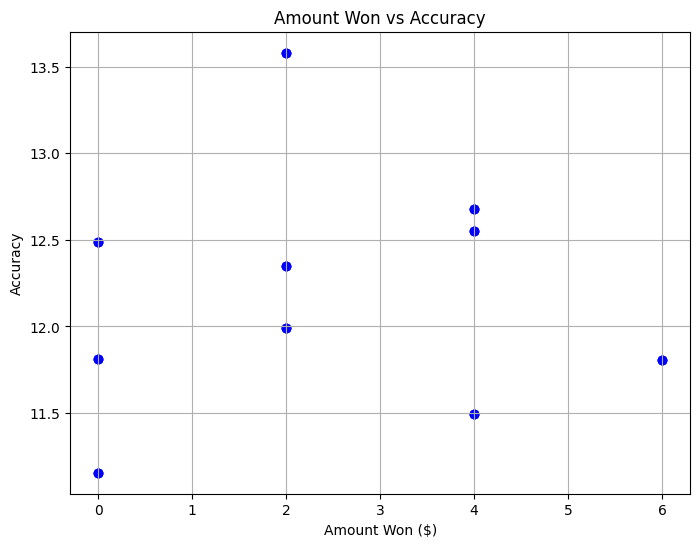